First Steps: gradCAM
- works for any model
- discriminates classes (change y_c index)

In [1]:
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from keras.preprocessing.image import img_to_array, load_img
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.keras.backend as K
import tensorflow.keras as keras
from tensorflow.keras.models import Model 
import wandb
import cv2 as cv
input_path = "C:/DL_Lab/IDRID_dataset/images/test/preprocessed/IDRiD_060.jpg"
#input_path = "C:/DL_Lab/IDRID_dataset_orig/images/train/IDRiD_001.jpg"

(1, 224, 224, 3)

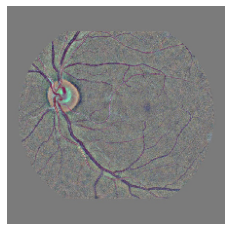

In [2]:
# load and import image with keras in RGB format
orig_image = load_img(input_path, target_size=(224,224))
image = np.expand_dims(orig_image, axis=0)
plt.imshow(orig_image)
plt.axis("off")
image.shape

In [3]:
# pretrained model
# model = ResNet50(input_shape=(224,224,3), include_top=True, weights="imagenet")

# our pretrained model
model = wandb.restore('model.h5', run_path="stuttgartteam8/diabetic_retinopathy/3q66vtl3")
model = tf.keras.models.load_model('model.h5')
model.summary()

vgg16 = VGG16(include_top=False, weights="imagenet")
w = model.get_layer("vgg16").get_weights()
vgg16.set_weights(w)
inputs=vgg16.input
x = vgg16.output

Model: "multi_class_vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
tf.cast (TFOpLambda)         (None, 224, 224, 3)       0         
_________________________________________________________________
tf.__operators__.getitem (Sl (None, 224, 224, 3)       0         
_________________________________________________________________
tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)       0         
_________________________________________________________________
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 256)         

In [4]:
'''SEQUENTIAL'''
# cut_model = keras.Sequential()
# for vgg_layer in model.get_layer("vgg16").layers:
#     cut_model.add(vgg_layer)
# for model_layer in model.layers[5:]:
#     cut_model.add(model_layer)
# cut_model.summary()

#tf.keras.utils.plot_model(cut_model, show_shapes=True)

'SEQUENTIAL'

In [5]:
'''FUNCTIONAL'''
# inputs = keras.layers.Input(shape=[224, 224, 3], dtype=tf.uint8, name="input_0")
# x = tf.cast(inputs, tf.float32)
# x = preprocess_input(x)

# for i, vgg_layer in enumerate(model.get_layer("vgg16").layers):
#     if i > 0:
#         x = vgg_layer(x)

# for model_layer in model.layers[5:]:
#     x = model_layer(x) 

# cut_model = Model(inputs=inputs, outputs=x)
# tf.keras.utils.plot_model(cut_model, show_shapes=True)
#print(model.layers[5:])

'FUNCTIONAL'

In [6]:
for model_layer in model.layers[5:]:
    print (model_layer.name)
    x = model.get_layer(model_layer.name)(x) 

global_average_pooling2d
dense
dropout
dense_1
dropout_1
dense_2
dropout_2
dense_3


In [7]:
# x = keras.layers.GlobalAveragePooling2D()(x)
# x = keras.layers.Dense(256, activation="relu")(x)
# x = keras.layers.Dropout(0.1)(x)
# x = keras.layers.Dense(64, activation="relu")(x)
# x = keras.layers.Dropout(0.1)(x)
# x = keras.layers.Dense(32, activation="relu")(x)
# x = keras.layers.Dropout(0.1)(x)
# x = keras.layers.Dense(5, activation="relu")(x)
# cut_model.get_layer("dense").set_weights(model.get_layer("dense").get_weights())
# cut_model.get_layer("dense_1").set_weights(model.get_layer("dense_1").get_weights())
# cut_model.get_layer("dense_2").set_weights(model.get_layer("dense_2").get_weights())
# cut_model.get_layer("dense_3").set_weights(model.get_layer("dense_3").get_weights())

In [8]:
cut_model = Model(inputs=inputs, outputs=x)
#cut_model.summary()

In [9]:
print(cut_model.predict(image))
print(model.predict(image))

[[0.2501405  0.2871499  0.04205719 0.15563767 0.2650147 ]]
[[0.11270795 0.16417691 0.07992021 0.23362793 0.40956697]]


In [10]:
gradModel = Model(inputs=cut_model.input, outputs=[cut_model.get_layer("block5_conv3").output, cut_model.output])

In [11]:
with tf.GradientTape() as tape:
    # get predictions from conv model and model
    inputs = tf.cast(image, tf.float32)
    (fmaps, preds) = gradModel(image)
    # get logit of winner-class
    y_c = preds[:,np.argmax(preds[:,])]

grads = tape.gradient(y_c, fmaps)

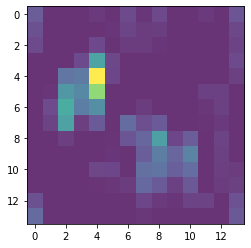

In [12]:
# apply global max pooling = collapse axes 0 and 1
weights = tf.reduce_mean(grads, axis=(0,1))
# calculate the class activation map
cam = tf.reduce_mean(fmaps[0] * weights, axis=2)
# apply relu 
cam = tf.nn.relu(cam)
plt.imshow(cam, cmap="viridis", alpha=0.8)

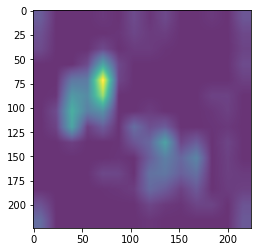

In [13]:
# upsample cam to original image size 224x224
ups_cam = cv.resize(cam.numpy(), (224, 224))
# normalize to range [0,1]
min = tf.math.reduce_min(ups_cam)
max = tf.math.reduce_max(ups_cam)
ups_cam = ((ups_cam - min) / (max - min))
plt.imshow(ups_cam, cmap="viridis", alpha=0.8)

(-0.5, 223.5, 223.5, -0.5)

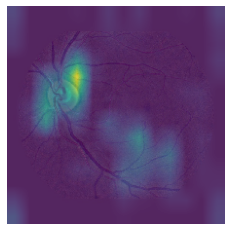

In [14]:
"overlay with open cv"
# change from 2d to 3d to match image shape
cam3d = np.expand_dims(ups_cam, axis=2)
cam3d = np.tile(cam3d, [1,1,3])
# opencv requires uint8 and [0,255]
cam3d = np.uint8(cam3d*255)
orig_image = np.uint8(orig_image)
# create colormap and convert to RGB
cam3d_hm = cv.applyColorMap(cam3d, cv.COLORMAP_VIRIDIS)
cam3d_hm = cv.cvtColor(cam3d_hm, cv.COLOR_BGR2RGB)
# overlay both images
overlay = cv.addWeighted(orig_image, 0.3, cam3d_hm, 0.7, 0)
plt.imshow(overlay)
plt.axis("off")

(-0.5, 223.5, 223.5, -0.5)

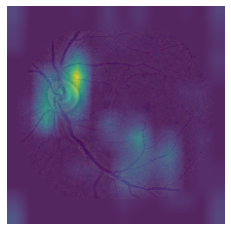

In [15]:
"overlay with open imshow"
plt.imshow(orig_image, alpha=1)
plt.imshow(ups_cam, cmap="viridis", alpha=0.7)
plt.axis("off")